# ***Environment Setup & Dependencies***

## ***Setup***

In [ ]:
%%capture
# Install necessary packages silently (Colab)
!pip install -q pandas numpy pyshark matplotlib tqdm scipy scapy

# Standard libraries
import os
import glob
import zipfile
import warnings
import collections
import ipaddress
import subprocess
import zlib
import math
import gdown
import shutil
from google.colab import files
import re


# Data analysis and plotting
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from tqdm import tqdm

# Network analysis and packet parsing
import pyshark
from scapy.all import IP, TCP, UDP, SCTP, Raw, PcapReader, conf, load_contrib, rdpcap
from scapy.contrib.gtp import GTP_U_Header

# Load Scapy contributions (e.g., GTP)
load_contrib('gtp')

# Register non-standard link-layer types
conf.l2types.register(156, IP)  # Generic IP registration
conf.l2types.register(149, IP)  # MAC-NR

# Shared folder link
folder_url = "https://drive.google.com/drive/folders/12Y3zycoUbahTPy7u_P3KGMkWHYlJpJrG?usp=drive_link"

# Temp folder for all downloads
tmp_dir = "/content/pcaps_temp"
os.makedirs(tmp_dir, exist_ok=True)

# Download everything in the folder
gdown.download_folder(folder_url, output=tmp_dir, quiet=False)

# CSV output directory
csv_dir = "/content/pcap_to_csv"
os.makedirs(csv_dir, exist_ok=True)

## ***Benign***

In [ ]:
BENIGN = True

# Final folder for only BENIGN pcaps
pcap_dir = "/content/pcaps_benign"
os.makedirs(pcap_dir, exist_ok=True)


for fname in os.listdir(tmp_dir):
    if fname.endswith("_BENIGN.pcap"):
        shutil.copy(os.path.join(tmp_dir, fname), pcap_dir)

print()
print("Filtered PCAPs saved in:", pcap_dir)
print("Files:", os.listdir(pcap_dir))


Filtered PCAPs saved in: /content/pcaps_benign
Files: ['gnb_mac_20250916_2HR_S2_BENIGN.pcap', 'gnb_rlc_20250916_2HR_S2_BENIGN.pcap', 'gnb_rlc_20250916_2HR_S1_BENIGN.pcap', 'gnb_mac_20250916_2HR_S1_BENIGN.pcap']


## ***Malicious***

In [ ]:
BENIGN = False

# Final folder for only MALICIOUS pcaps
pcap_dir = "/content/pcaps_malicious"
os.makedirs(pcap_dir, exist_ok=True)

# Filter: only copy files with "FLOOD" in their name
for fname in os.listdir(tmp_dir):
    if "FLOOD" in fname.upper():
        src = os.path.join(tmp_dir, fname)
        dst = os.path.join(pcap_dir, fname)
        shutil.copy(src, dst)


print()
print("Filtered PCAPs saved in:", pcap_dir)
print("Files:", os.listdir(pcap_dir))


Filtered PCAPs saved in: /content/pcaps_malicious
Files: ['gnb_rlc_20250925_2HR_S1_FLOOD.pcap', 'gnb_mac_20250925_2HR_S1_FLOOD.pcap']


# ***Functions***

In [ ]:
def shannon_entropy(data: bytes) -> float:
    """
    Computes Shannon entropy of a byte sequence.
    """
    if not data:
        return 0.0
    byte_counts = np.bincount(np.frombuffer(data, dtype=np.uint8), minlength=256)
    probs = byte_counts / len(data)
    return -sum(p * math.log2(p) for p in probs if p > 0)


def parse_ueid_from_raw_heuristic(raw_bytes: bytes, pkt_type="unknown"):
    """
    Extract UEID from packet bytes based on known offsets.
    Supports 'gnb_mac' and 'gnb_rlc' types.
    """
    if not raw_bytes:
        return None

    if pkt_type == "gnb_mac":
        UEID_OFFSET = 0x13
    elif pkt_type == "gnb_rlc":
        UEID_OFFSET = 0x14
    else:
        return None

    if len(raw_bytes) <= UEID_OFFSET:
        return None

    ueid = raw_bytes[UEID_OFFSET] & 0xFF
    return ueid if ueid != 0 else None

def extract_universal_features(pkt, pkt_type="unknown"):
    """
    Extract universal features from a packet.
    Includes timing, byte-level stats, IP/transport info, and UEID.
    """
    features = collections.defaultdict(lambda: None)
    try:
        features['timestamp'] = float(pkt.time)
        features['packet_len'] = len(pkt)

        raw_bytes = bytes(pkt.original) if hasattr(pkt, "original") else bytes(pkt)
        if raw_bytes:

            features['payload_entropy'] = shannon_entropy(raw_bytes)
            features['unique_bytes'] = len(set(raw_bytes))
            features['compression_ratio'] = len(zlib.compress(raw_bytes)) / len(raw_bytes)
            features['byte_mean'] = np.mean(list(raw_bytes))
            features['byte_std'] = np.std(list(raw_bytes))
            features['byte_min'] = np.min(list(raw_bytes))
            features['byte_max'] = np.max(list(raw_bytes))

            # 1. N-gram byte frequency (here: 2-grams)
            n = 2
            if len(raw_bytes) >= n:
                ngrams = [tuple(raw_bytes[i:i+n]) for i in range(len(raw_bytes)-n+1)]
                ngram_counts = collections.Counter(ngrams)
                total_ngrams = sum(ngram_counts.values())
                # normalize top-3 most common 2-grams
                for idx, (ng, cnt) in enumerate(ngram_counts.most_common(3)):
                    features[f'ngram_freq_top{idx+1}'] = cnt / total_ngrams

            # 2. Header/payload ratio (assume 42B Ethernet+IP+UDP/TCP header baseline)
            header_len = min(42, len(raw_bytes))
            payload_len = max(1, len(raw_bytes) - header_len)
            features['header_payload_ratio'] = header_len / payload_len

            # 3. High small-packet ratio (flag per packet)
            SMALL_PKT_THRESHOLD = 100  # bytes
            features['small_pkt_flag'] = 1 if len(raw_bytes) <= SMALL_PKT_THRESHOLD else 0

        # Packet type and UEID
        features['ueid'] = parse_ueid_from_raw_heuristic(raw_bytes, pkt_type)

    except Exception as e:
        features['error'] = str(e)

    return dict(features)



def aggregate_to_flows(df, window_size=1, attack_ueids=None):
    """
    Aggregates packets into flows based on time window and UEID.
    Computes flow-level metrics and labels if attack UEIDs are provided.
    """
    df = df.sort_values(by='timestamp').reset_index(drop=True)
    df['flow_window'] = ((df['timestamp'] - df['timestamp'].min()) // window_size).astype(int)

    # Create a unique flow ID
    def make_flow_id(x):
        if pd.notna(x.get('ueid')):
            return f"TWIN-{x.flow_window}_UEID-{x.ueid}"
        else:
            return f"TWIN-{x.flow_window}"

    df['flow_id'] = df.apply(make_flow_id, axis=1)
    df['inter_arrival_time'] = df.groupby('flow_id')['timestamp'].diff()

    # Aggregation operations
    agg_ops = {
        'flow_duration': ('timestamp', lambda x: x.max() - x.min()),
        'packet_count': ('timestamp', 'count'),
        'total_bytes': ('packet_len', 'sum'),
        'mean_pkt_len': ('packet_len', 'mean'),
        'std_pkt_len': ('packet_len', 'std'),
        'min_pkt_len': ('packet_len', 'min'),
        'q1_pkt_len': ('packet_len', lambda x: np.percentile(x, 25)),
        'q3_pkt_len': ('packet_len', lambda x: np.percentile(x, 75)),
        'max_pkt_len': ('packet_len', 'max'),
        'mean_iat': ('inter_arrival_time', 'mean'),
        'std_iat': ('inter_arrival_time', 'std'),
        'min_iat': ('inter_arrival_time', 'min'),
        'max_iat': ('inter_arrival_time', 'max'),
        'pkt_rate': ('timestamp', lambda x: len(x) / (x.max() - x.min() + 1e-6)),
        'byte_rate': ('packet_len', lambda x: x.sum() / (df.loc[x.index, 'timestamp'].max() - df.loc[x.index, 'timestamp'].min() + 1e-6)),
        'iat_cov': ('inter_arrival_time', lambda x: (x.std()/x.mean()) if x.mean() > 0 else 0),
    }

    flow_features = df.groupby('flow_id').agg(**agg_ops).reset_index()
    df_with_flows = df.merge(flow_features, on='flow_id', how='left')
    df_with_flows.fillna(0, inplace=True)

    if 'ueid' not in df_with_flows.columns:
        df_with_flows['ueid'] = None

    # Labeling
    if attack_ueids is not None:
        attack_ueids = set(attack_ueids)
        df_with_flows['label'] = df_with_flows['ueid'].apply(lambda u: "DoS" if u in attack_ueids else "Benign")
    else:
        df_with_flows['label'] = "Benign"

    return df_with_flows


def process_pcap_to_csv(filepath, pkt_type="unknown", attack_ueids=None):
    """
    Parses a PCAP file, extracts features, aggregates into flows, and returns a dataframe.
    """
    print(f"Processing file: {os.path.basename(filepath)}")

    packets_data = []
    with PcapReader(filepath) as pcap:
        for pkt in pcap:
            features = extract_universal_features(pkt, pkt_type=pkt_type)
            if features:
                packets_data.append(features)

    if not packets_data:
        print(f"Warning: No processable packets found in {filepath}")
        return pd.DataFrame()

    df_packets = pd.DataFrame(packets_data)
    df_packets_with_flow = aggregate_to_flows(df_packets, window_size=1, attack_ueids=attack_ueids)

    # Drop intermediate columns
    df_packets_with_flow = df_packets_with_flow.drop(columns=['flow_id', 'flow_window', 'inter_arrival_time'], errors='ignore')

    # Ensure UEID exists
    if 'ueid' not in df_packets_with_flow.columns:
        df_packets_with_flow['ueid'] = None

    # Column ordering
    flow_cols = [
        'flow_duration', 'packet_count', 'total_bytes',
        'mean_pkt_len', 'std_pkt_len', 'min_pkt_len',
        'q1_pkt_len', 'q3_pkt_len', 'max_pkt_len',
        'mean_iat', 'std_iat', 'min_iat', 'max_iat',
        'pkt_rate', 'byte_rate', 'iat_cov',
        'small_pkt_ratio'
    ]

    packet_cols = [
        'timestamp', 'packet_len',
        'payload_entropy', 'unique_bytes', 'compression_ratio',
        'byte_mean', 'byte_std', 'byte_min', 'byte_max',
        'ngram_freq_top1', 'ngram_freq_top2', 'ngram_freq_top3',
        'header_payload_ratio', 'small_pkt_flag',

    ]

    label_cols = ['ueid', 'label']

    # Keep only columns that exist
    ordered_cols =  [c for c in flow_cols if c in df_packets_with_flow.columns] + \
                    [c for c in packet_cols if c in df_packets_with_flow.columns] + \
                    [c for c in label_cols if c in df_packets_with_flow.columns]

    # Append any extra columns Pandas generated
    remaining = [c for c in df_packets_with_flow.columns if c not in ordered_cols]
    final_cols = ordered_cols + remaining

    return df_packets_with_flow[final_cols]


# ***Main Execution***

In [ ]:
# Load GTP contribution
try:
    load_contrib('gtp')
    from scapy.contrib.gtp import GTP_U_Header
except ImportError:
    GTP_U_Header = None

# Check PCAP directory existence
if os.path.exists(pcap_dir):
    print(f"Files found: {os.listdir(pcap_dir)}")
else:
    print("Error: The PCAP directory was not found. Please check your path.")

# Find all PCAP files
pcap_files = glob.glob(os.path.join(pcap_dir, "*.pcap*"))
if not pcap_files:
    print(f"Warning: No PCAP files found in the directory: {pcap_dir}")

# Process each PCAP
for filepath in sorted(pcap_files):
    base_filename = os.path.basename(filepath)
    filename_without_ext = os.path.splitext(base_filename)[0]

    # Detect packet type from filename
    if "gnb_mac" in filename_without_ext.lower():
        pkt_type = "gnb_mac"
    elif "gnb_rlc" in filename_without_ext.lower():
        pkt_type = "gnb_rlc"
    else:
        pkt_type = "unknown"

    output_csv_path = os.path.join(csv_dir, f"{filename_without_ext}_flows.csv")

    print("="*80)
    if (BENIGN):
      flow_df = process_pcap_to_csv(filepath, pkt_type=pkt_type, attack_ueids=None)
    else:
      flow_df = process_pcap_to_csv(filepath, pkt_type=pkt_type, attack_ueids=[1])

    if not flow_df.empty:
        os.makedirs(csv_dir, exist_ok=True)
        flow_df.to_csv(output_csv_path, index=False)
        print(f"Success! Saved {len(flow_df)} lines")
    else:
        print(f"Skipped saving CSV for '{base_filename}' as no data was extracted.")

print("="*80)

Files found: ['gnb_mac_20250916_2HR_S2_BENIGN.pcap', 'gnb_rlc_20250916_2HR_S2_BENIGN.pcap', 'gnb_rlc_20250916_2HR_S1_BENIGN.pcap', 'gnb_mac_20250916_2HR_S1_BENIGN.pcap']
Processing file: gnb_mac_20250916_2HR_S1_BENIGN.pcap
Success! Saved 64128 lines
Processing file: gnb_mac_20250916_2HR_S2_BENIGN.pcap
Success! Saved 71632 lines
Processing file: gnb_rlc_20250916_2HR_S1_BENIGN.pcap
Success! Saved 52896 lines
Processing file: gnb_rlc_20250916_2HR_S2_BENIGN.pcap
Success! Saved 59508 lines


# ***Download***

In [ ]:
if BENIGN:
    traffic_type = "benign"
elif not BENIGN:
    traffic_type = "malicious"
else:
    traffic_type = "unknown"

output_zip_path = f"/content/{traffic_type}_traffic_csv_files.zip"

csv_files_to_zip = glob.glob(os.path.join(csv_dir, "*.csv"))

if not csv_files_to_zip:
    print("No CSV files were found to download.")
else:
    print(f"Compressing {len(csv_files_to_zip)} CSV file(s) into a ZIP archive...")
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in tqdm(csv_files_to_zip, desc="Zipping files"):
            zipf.write(file, os.path.basename(file))
    print("Starting download...")

    files.download(output_zip_path)

Compressing 2 CSV file(s) into a ZIP archive...


Zipping files: 100%|██████████| 2/2 [00:05<00:00,  2.52s/it]

Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ***Statistics***

In [ ]:
print("="*80)
print("DATASET ANALYSIS")
print("="*80)


csv_files = glob.glob(os.path.join(csv_dir, "*_flows.csv"))

if not csv_files:
    print(f" No CSV files found in {csv_dir}")
else:

    mac_records = 0
    rlc_records = 0
    total_records = 0

    benign_count = 0
    dos_count = 0

    mac_files = []
    rlc_files = []

    total_size_bytes = 0

    print(f"\n Found {len(csv_files)} CSV file(s)\n")


    for csv_file in sorted(csv_files):
        filename = os.path.basename(csv_file)
        file_size = os.path.getsize(csv_file)
        total_size_bytes += file_size


        df = pd.read_csv(csv_file)
        num_rows = len(df)
        total_records += num_rows


        if "gnb_mac" in filename.lower():
            mac_records += num_rows
            mac_files.append(filename)
            pkt_type = "MAC"
        elif "gnb_rlc" in filename.lower():
            rlc_records += num_rows
            rlc_files.append(filename)
            pkt_type = "RLC"
        else:
            pkt_type = "Unknown"

        if 'label' in df.columns:
            benign_in_file = (df['label'] == 'Benign').sum()
            dos_in_file = (df['label'] == 'DoS').sum()
            benign_count += benign_in_file
            dos_count += dos_in_file

            print(f"  {pkt_type:8s} | {filename:50s} | {num_rows:6d} rows | Benign: {benign_in_file:5d} | DoS: {dos_in_file:5d}")
        else:
            print(f"  {pkt_type:8s} | {filename:50s} | {num_rows:6d} rows | (no label column)")


    print("\n" + "="*80)
    print(" RECORD COUNTS")
    print("="*80)
    print(f"  MAC files:        {len(mac_files):3d} file(s)  →  {mac_records:,} records")
    print(f"  RLC files:        {len(rlc_files):3d} file(s)  →  {rlc_records:,} records")
    print(f"  {'─'*50}")
    print(f"  TOTAL:            {len(csv_files):3d} file(s)  →  {total_records:,} records")

    print("\n" + "="*80)
    print("  LABEL DISTRIBUTION")
    print("="*80)
    if benign_count > 0 or dos_count > 0:
        total_labeled = benign_count + dos_count
        benign_pct = (benign_count / total_labeled * 100) if total_labeled > 0 else 0
        dos_pct = (dos_count / total_labeled * 100) if total_labeled > 0 else 0

        print(f"  Benign:           {benign_count:,} records  ({benign_pct:.2f}%)")
        print(f"  DoS:              {dos_count:,} records  ({dos_pct:.2f}%)")
        print(f"  {'─'*50}")
        print(f"  TOTAL LABELED:    {total_labeled:,} records")
    else:
        print("    No label information found in CSV files")

    print("\n" + "="*80)
    print(" DATASET SIZE")
    print("="*80)
    size_mb = total_size_bytes / (1024 * 1024)
    size_gb = total_size_bytes / (1024 * 1024 * 1024)

    if size_gb >= 1:
        print(f"  Total Size:       {size_gb:.2f} GB  ({size_mb:.2f} MB)")
    else:
        print(f"  Total Size:       {size_mb:.2f} MB")

    print(f"  Average per file: {(size_mb / len(csv_files)):.2f} MB")

    print("\n" + "="*80)

DATASET ANALYSIS

 Found 6 CSV file(s)

  MAC      | gnb_mac_20250916_2HR_S1_BENIGN_flows.csv           |  64128 rows | Benign: 64128 | DoS:     0
  MAC      | gnb_mac_20250916_2HR_S2_BENIGN_flows.csv           |  71632 rows | Benign: 71632 | DoS:     0
  MAC      | gnb_mac_20250925_2HR_S1_FLOOD_flows.csv            | 221043 rows | Benign: 171240 | DoS: 49803
  RLC      | gnb_rlc_20250916_2HR_S1_BENIGN_flows.csv           |  52896 rows | Benign: 52896 | DoS:     0
  RLC      | gnb_rlc_20250916_2HR_S2_BENIGN_flows.csv           |  59508 rows | Benign: 59508 | DoS:     0
  RLC      | gnb_rlc_20250925_2HR_S1_FLOOD_flows.csv            | 210868 rows | Benign: 175326 | DoS: 35542

 RECORD COUNTS
  MAC files:          3 file(s)  →  356,803 records
  RLC files:          3 file(s)  →  323,272 records
  ──────────────────────────────────────────────────
  TOTAL:              6 file(s)  →  680,075 records

  LABEL DISTRIBUTION
  Benign:           594,730 records  (87.45%)
  DoS:              85,

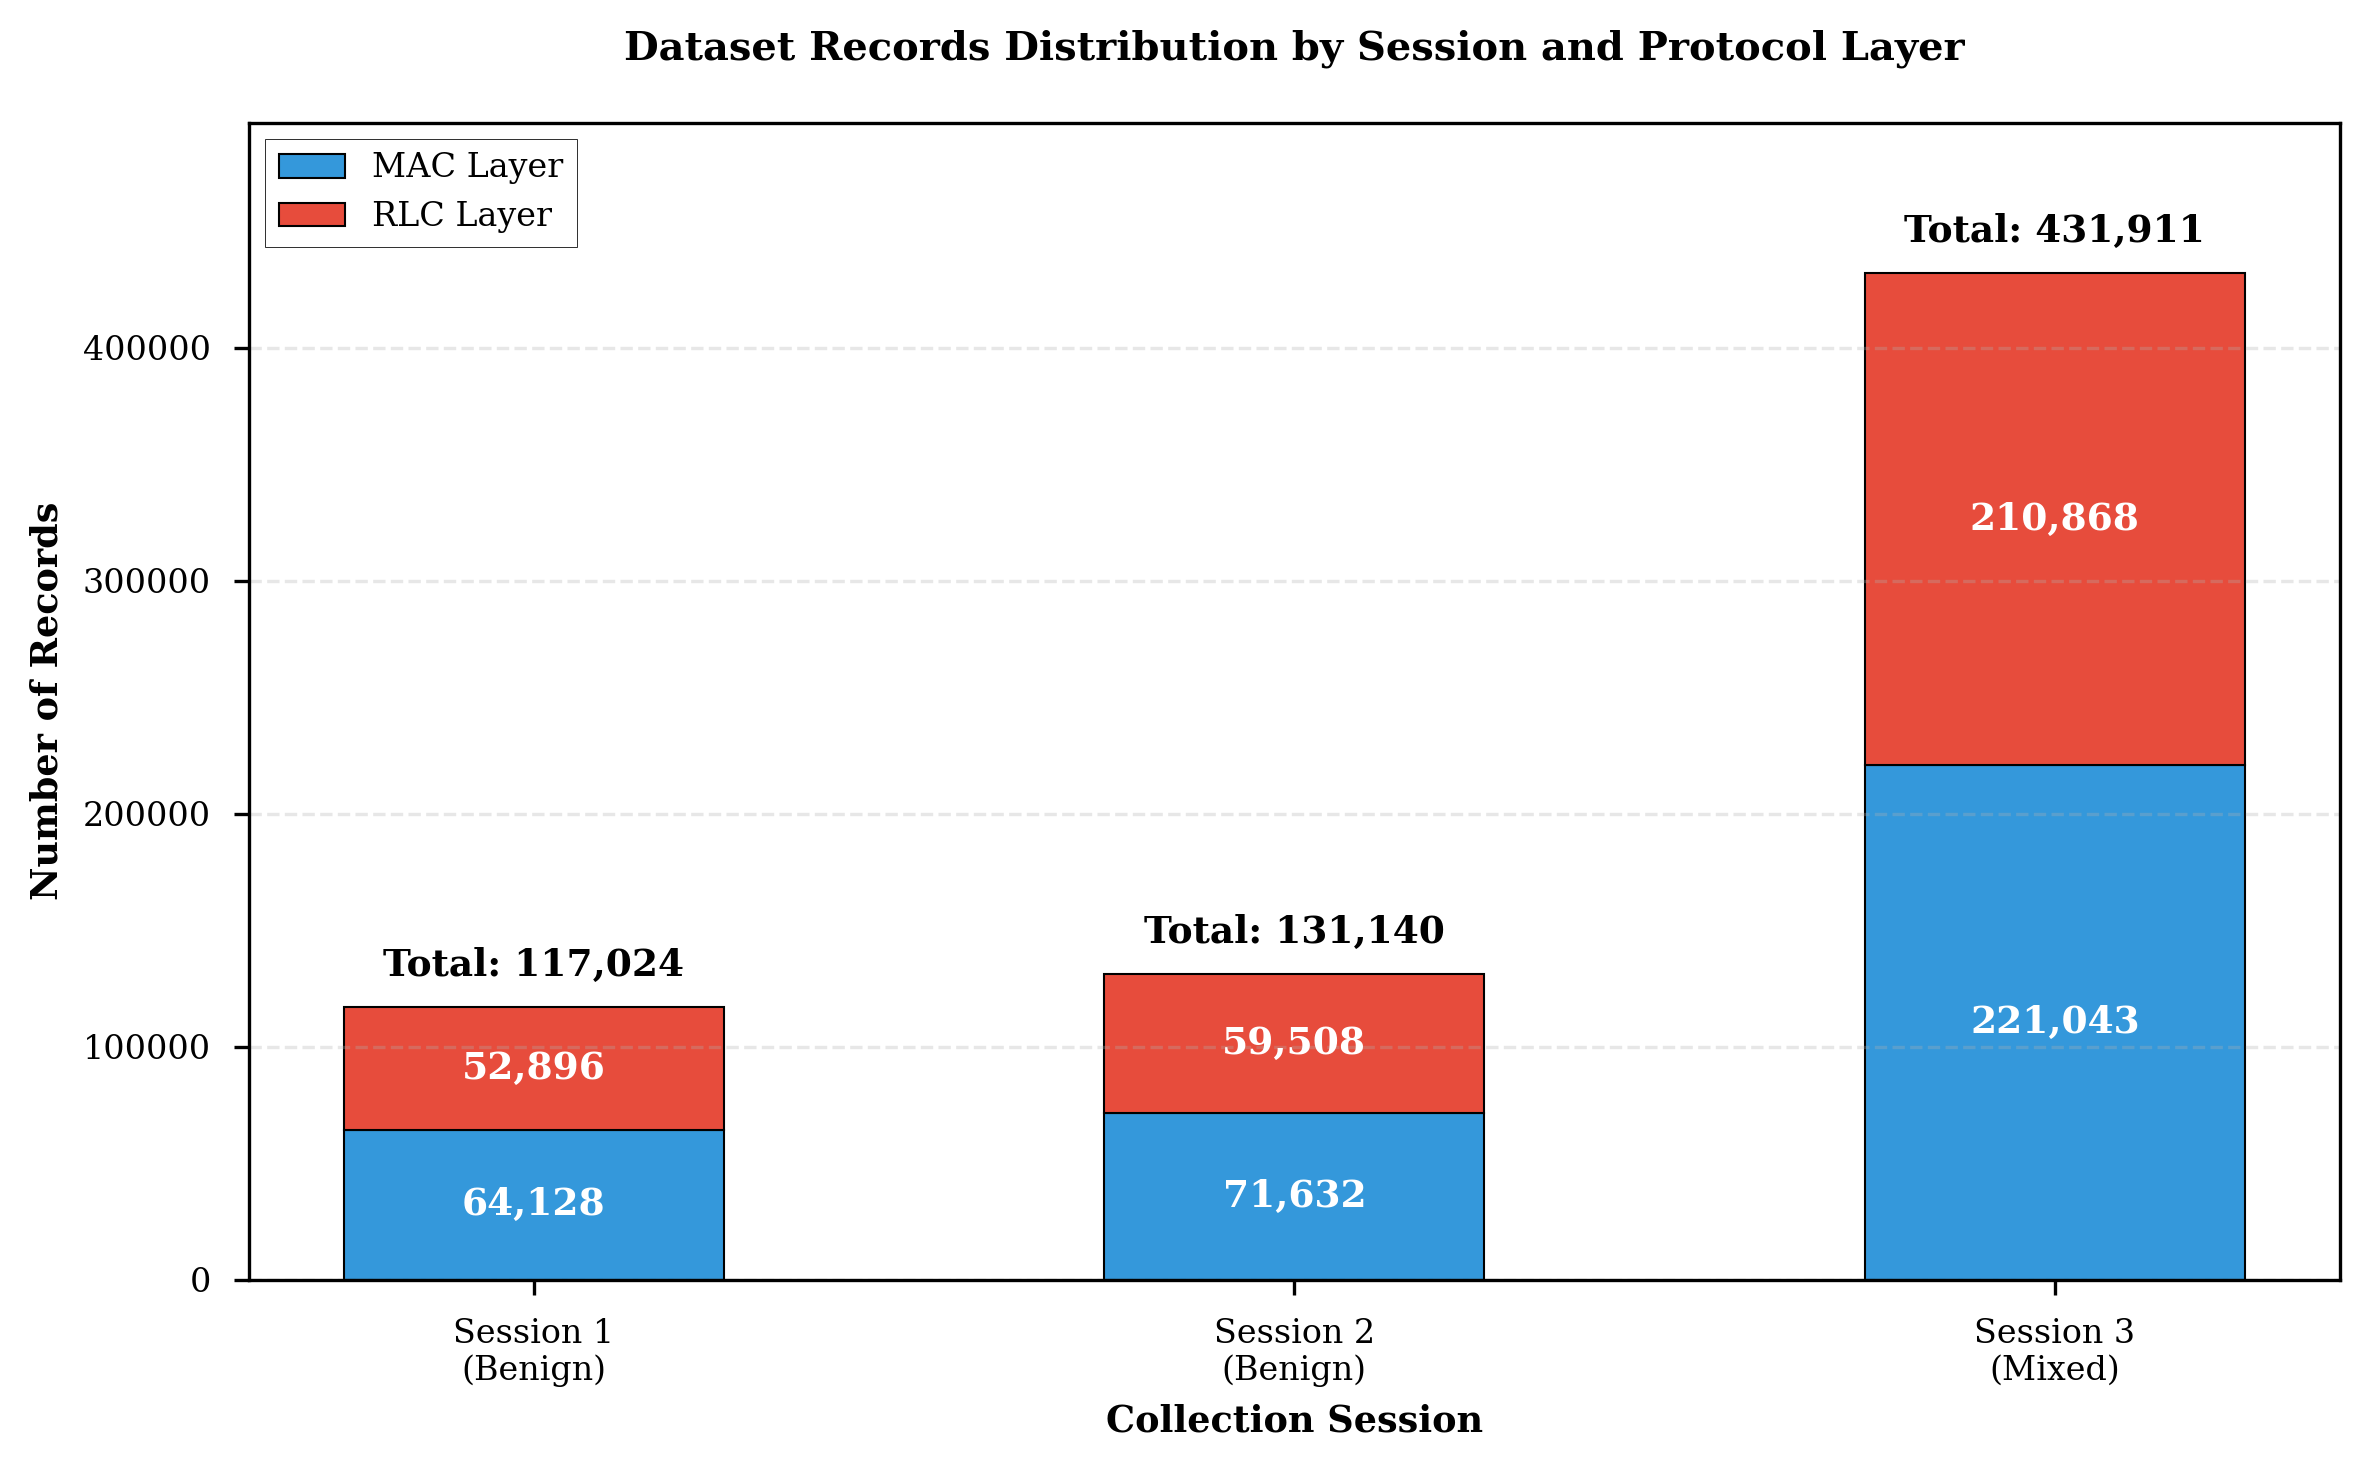

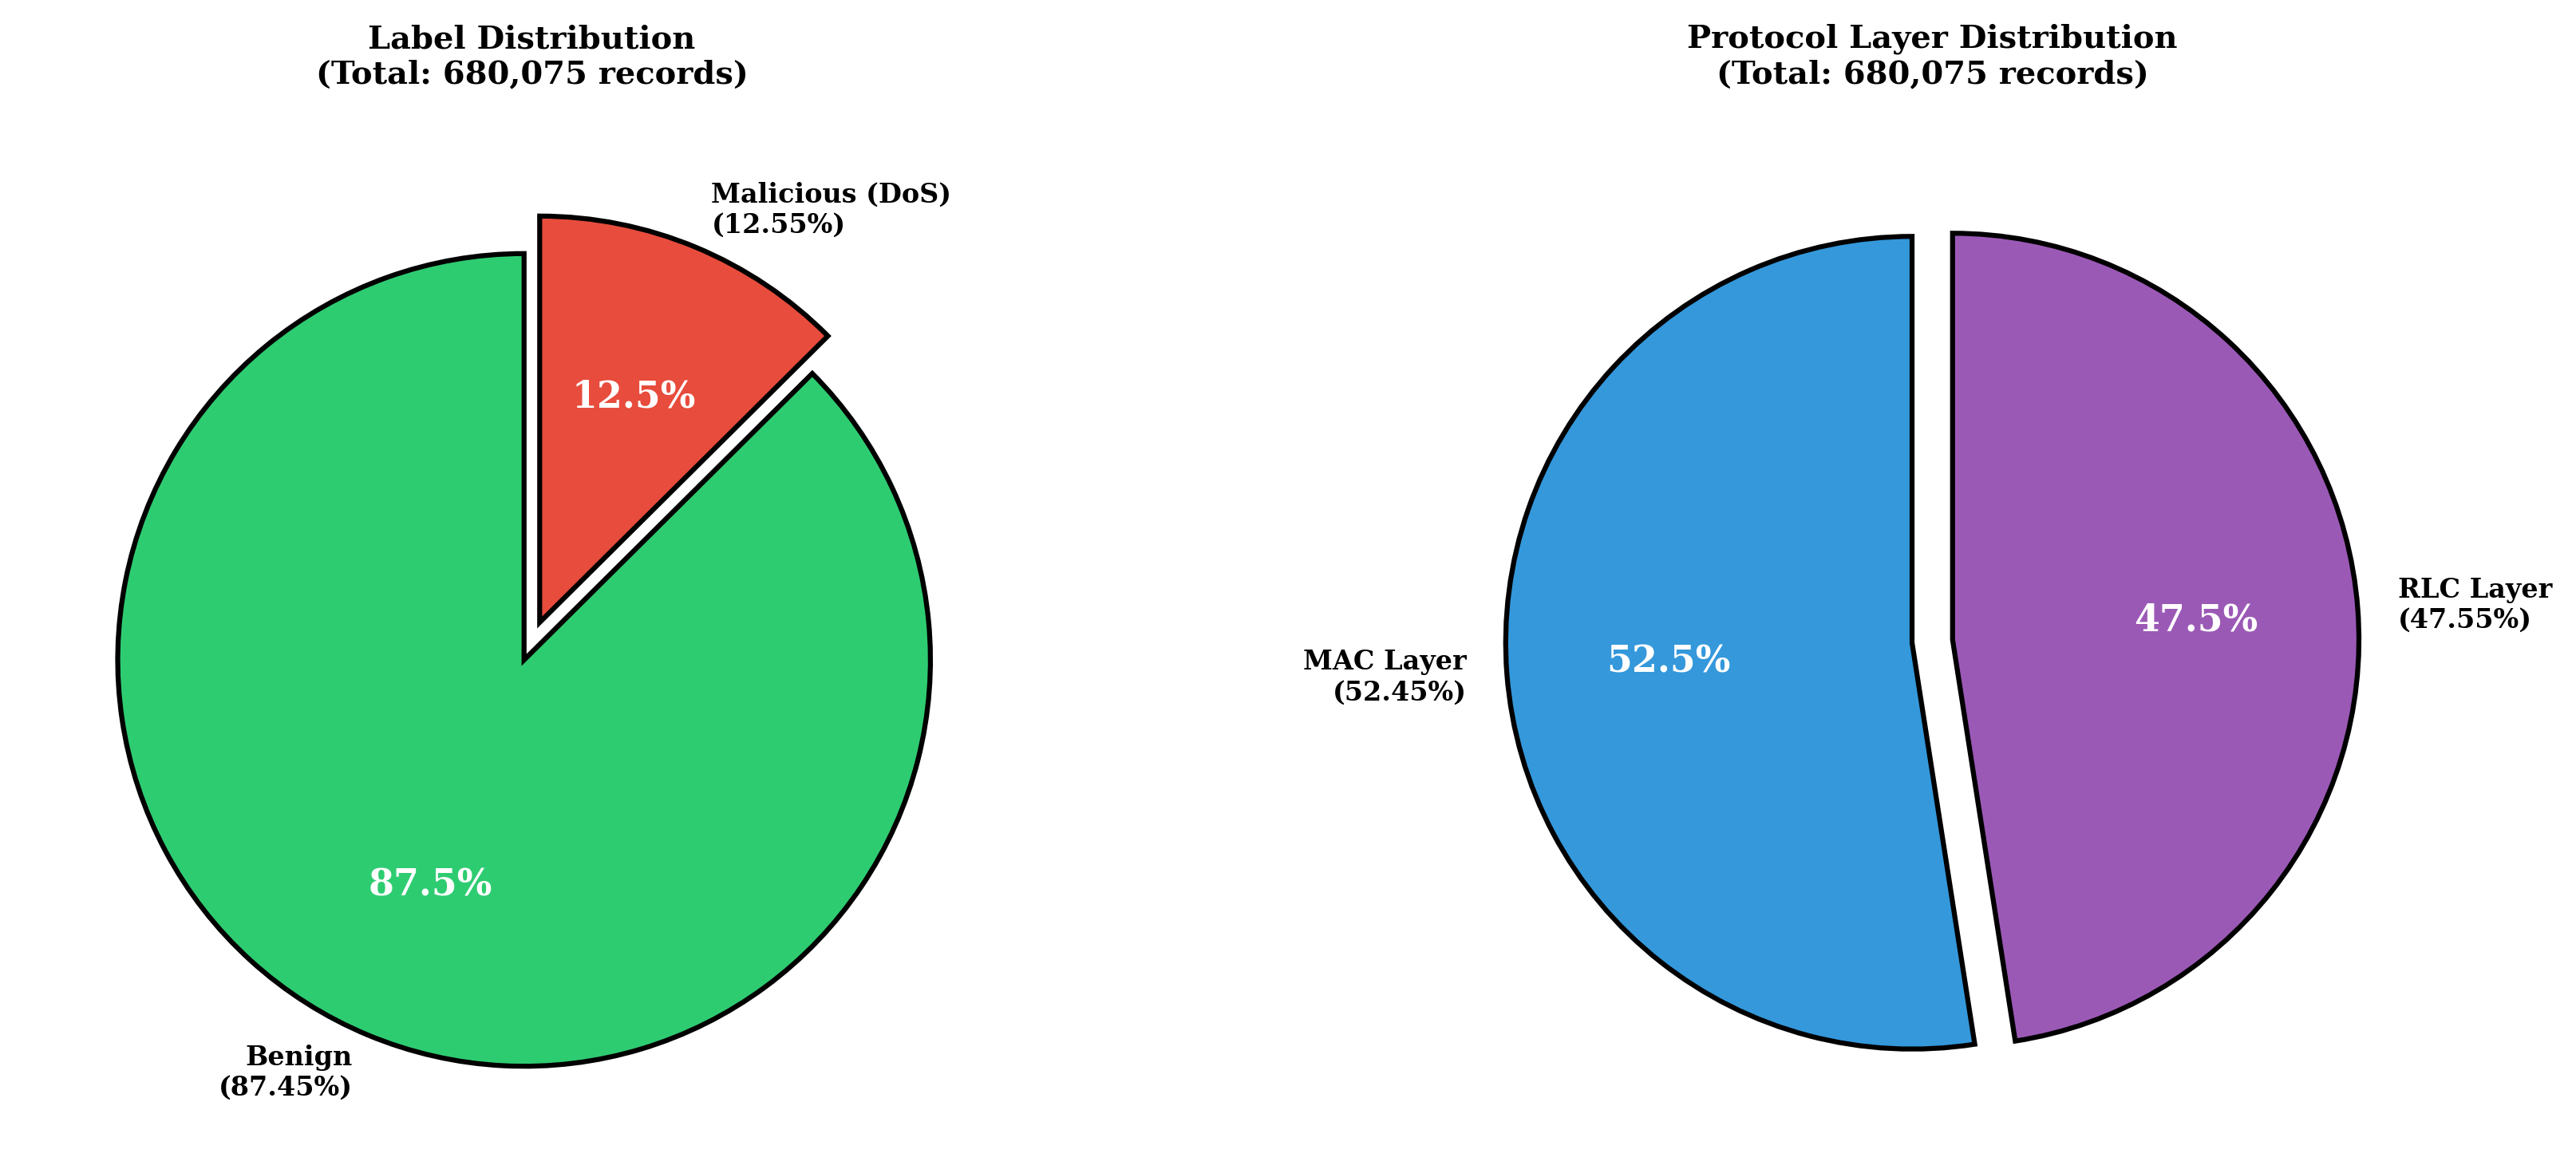

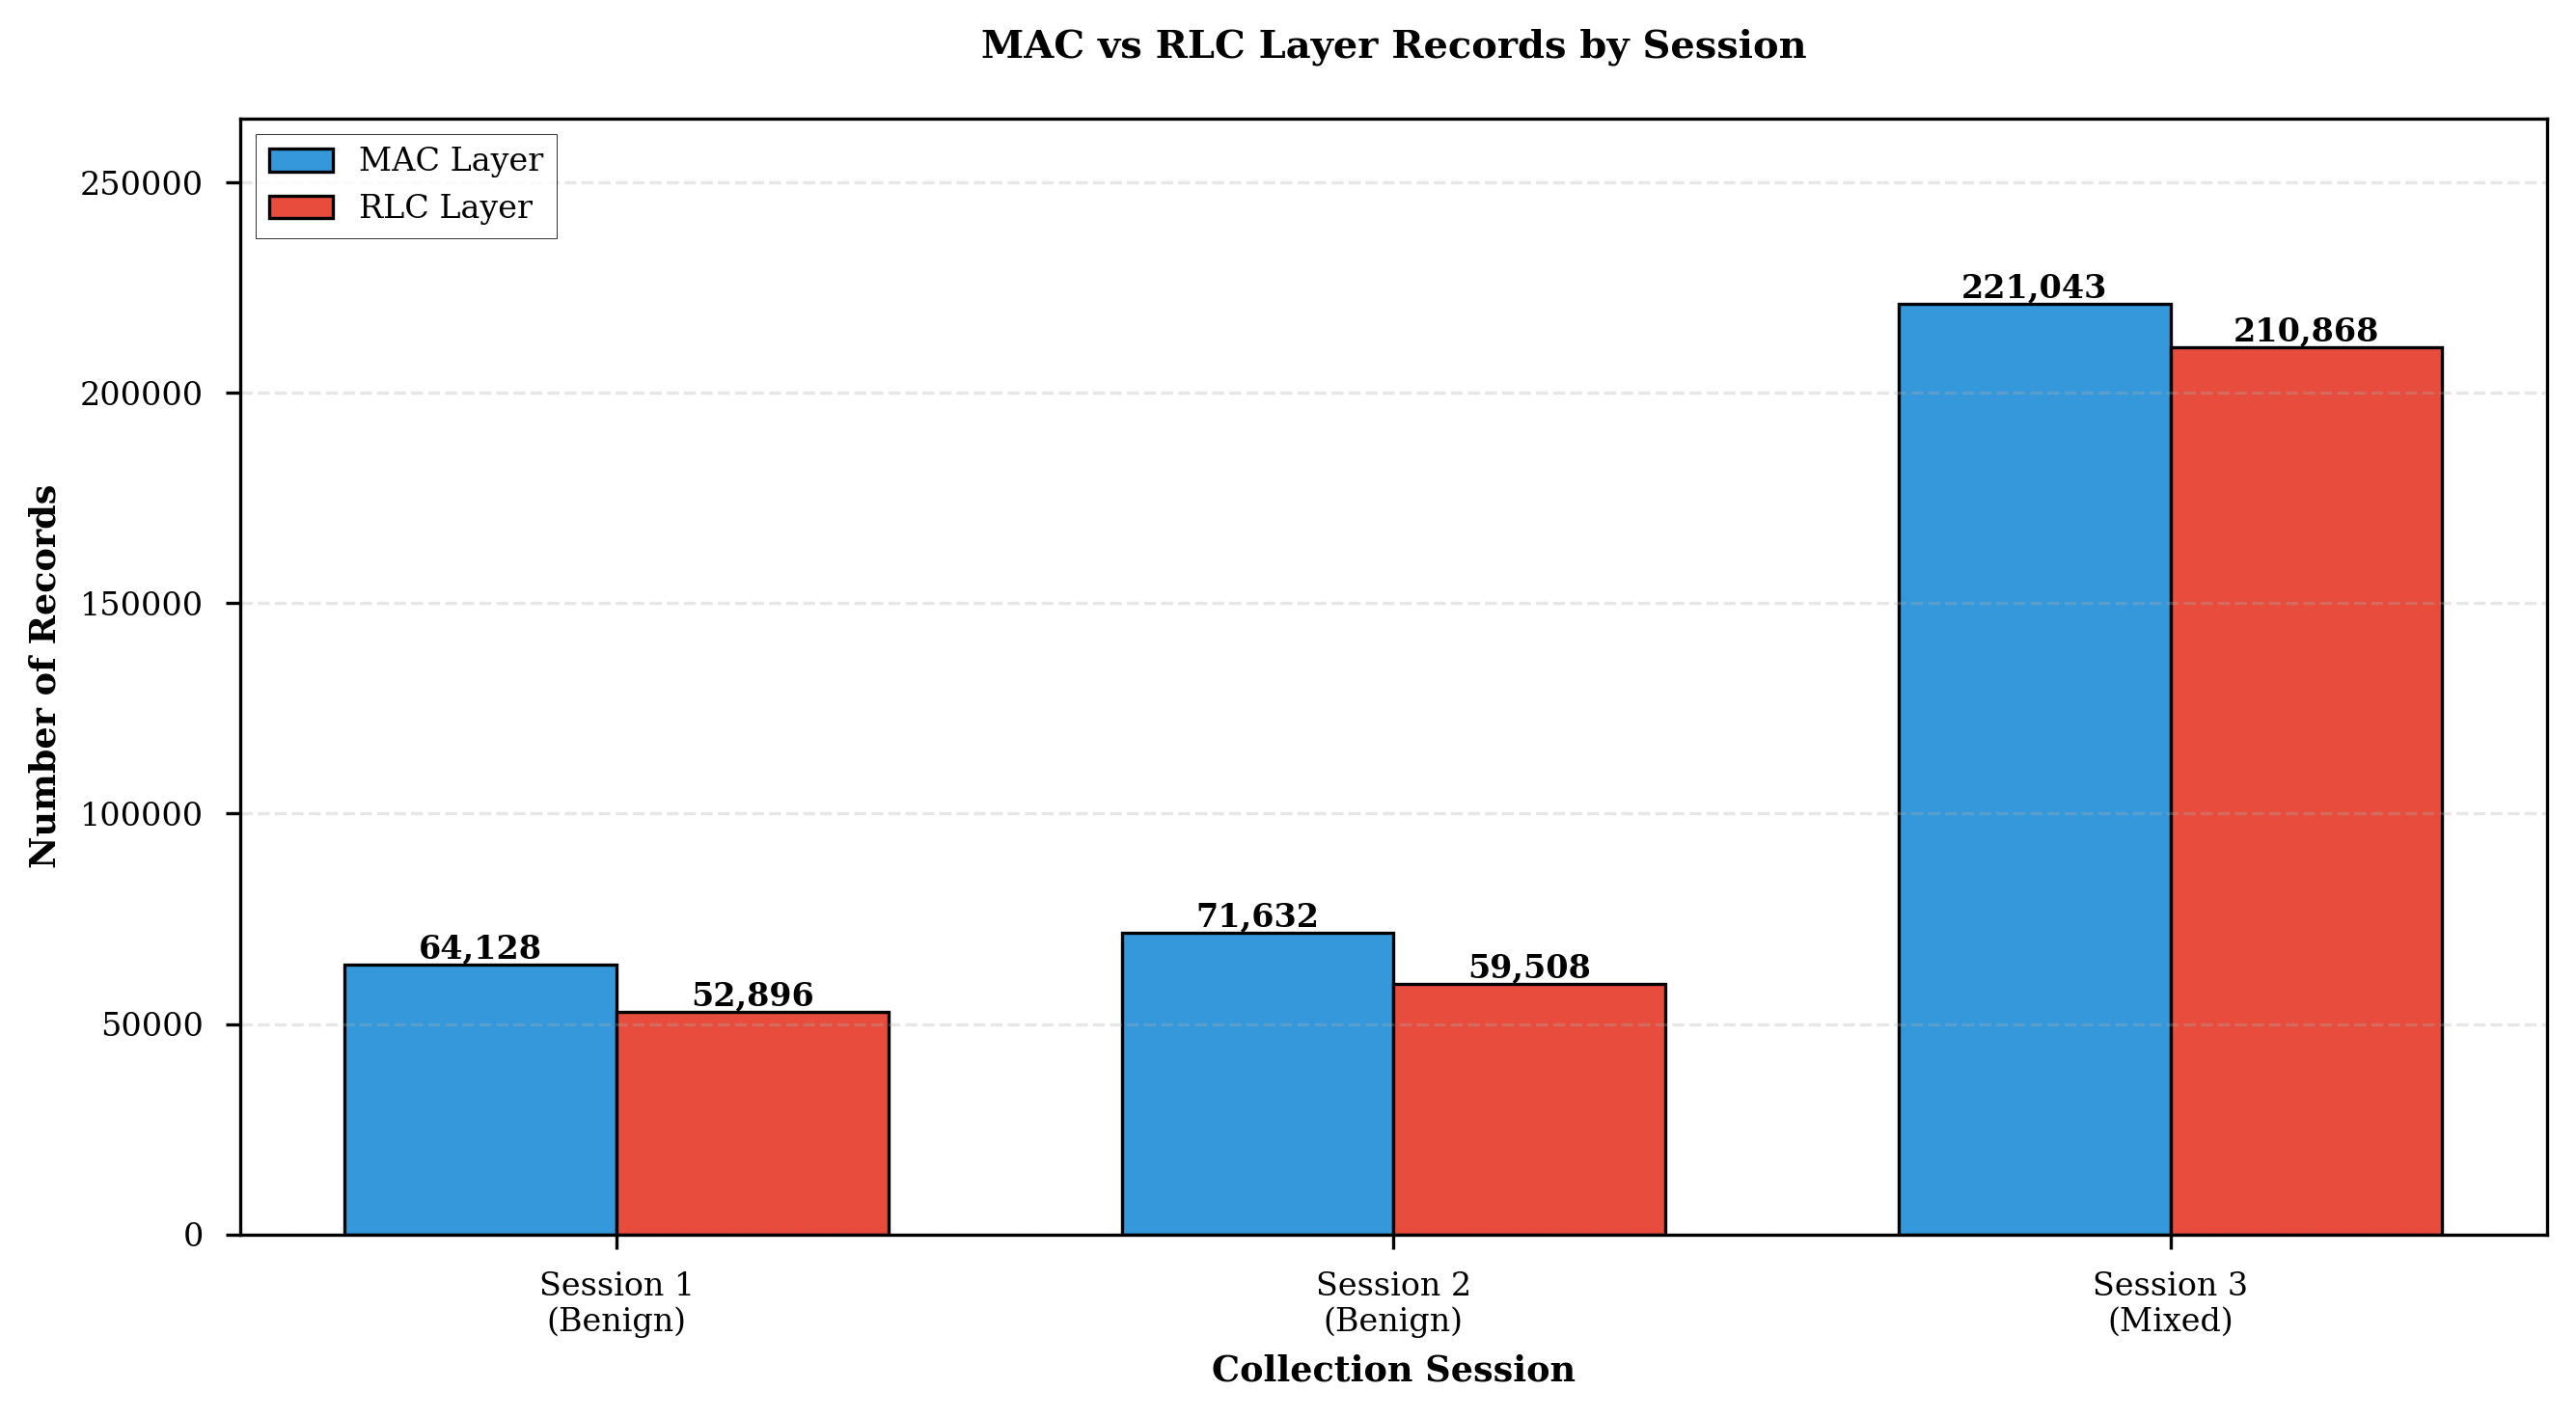

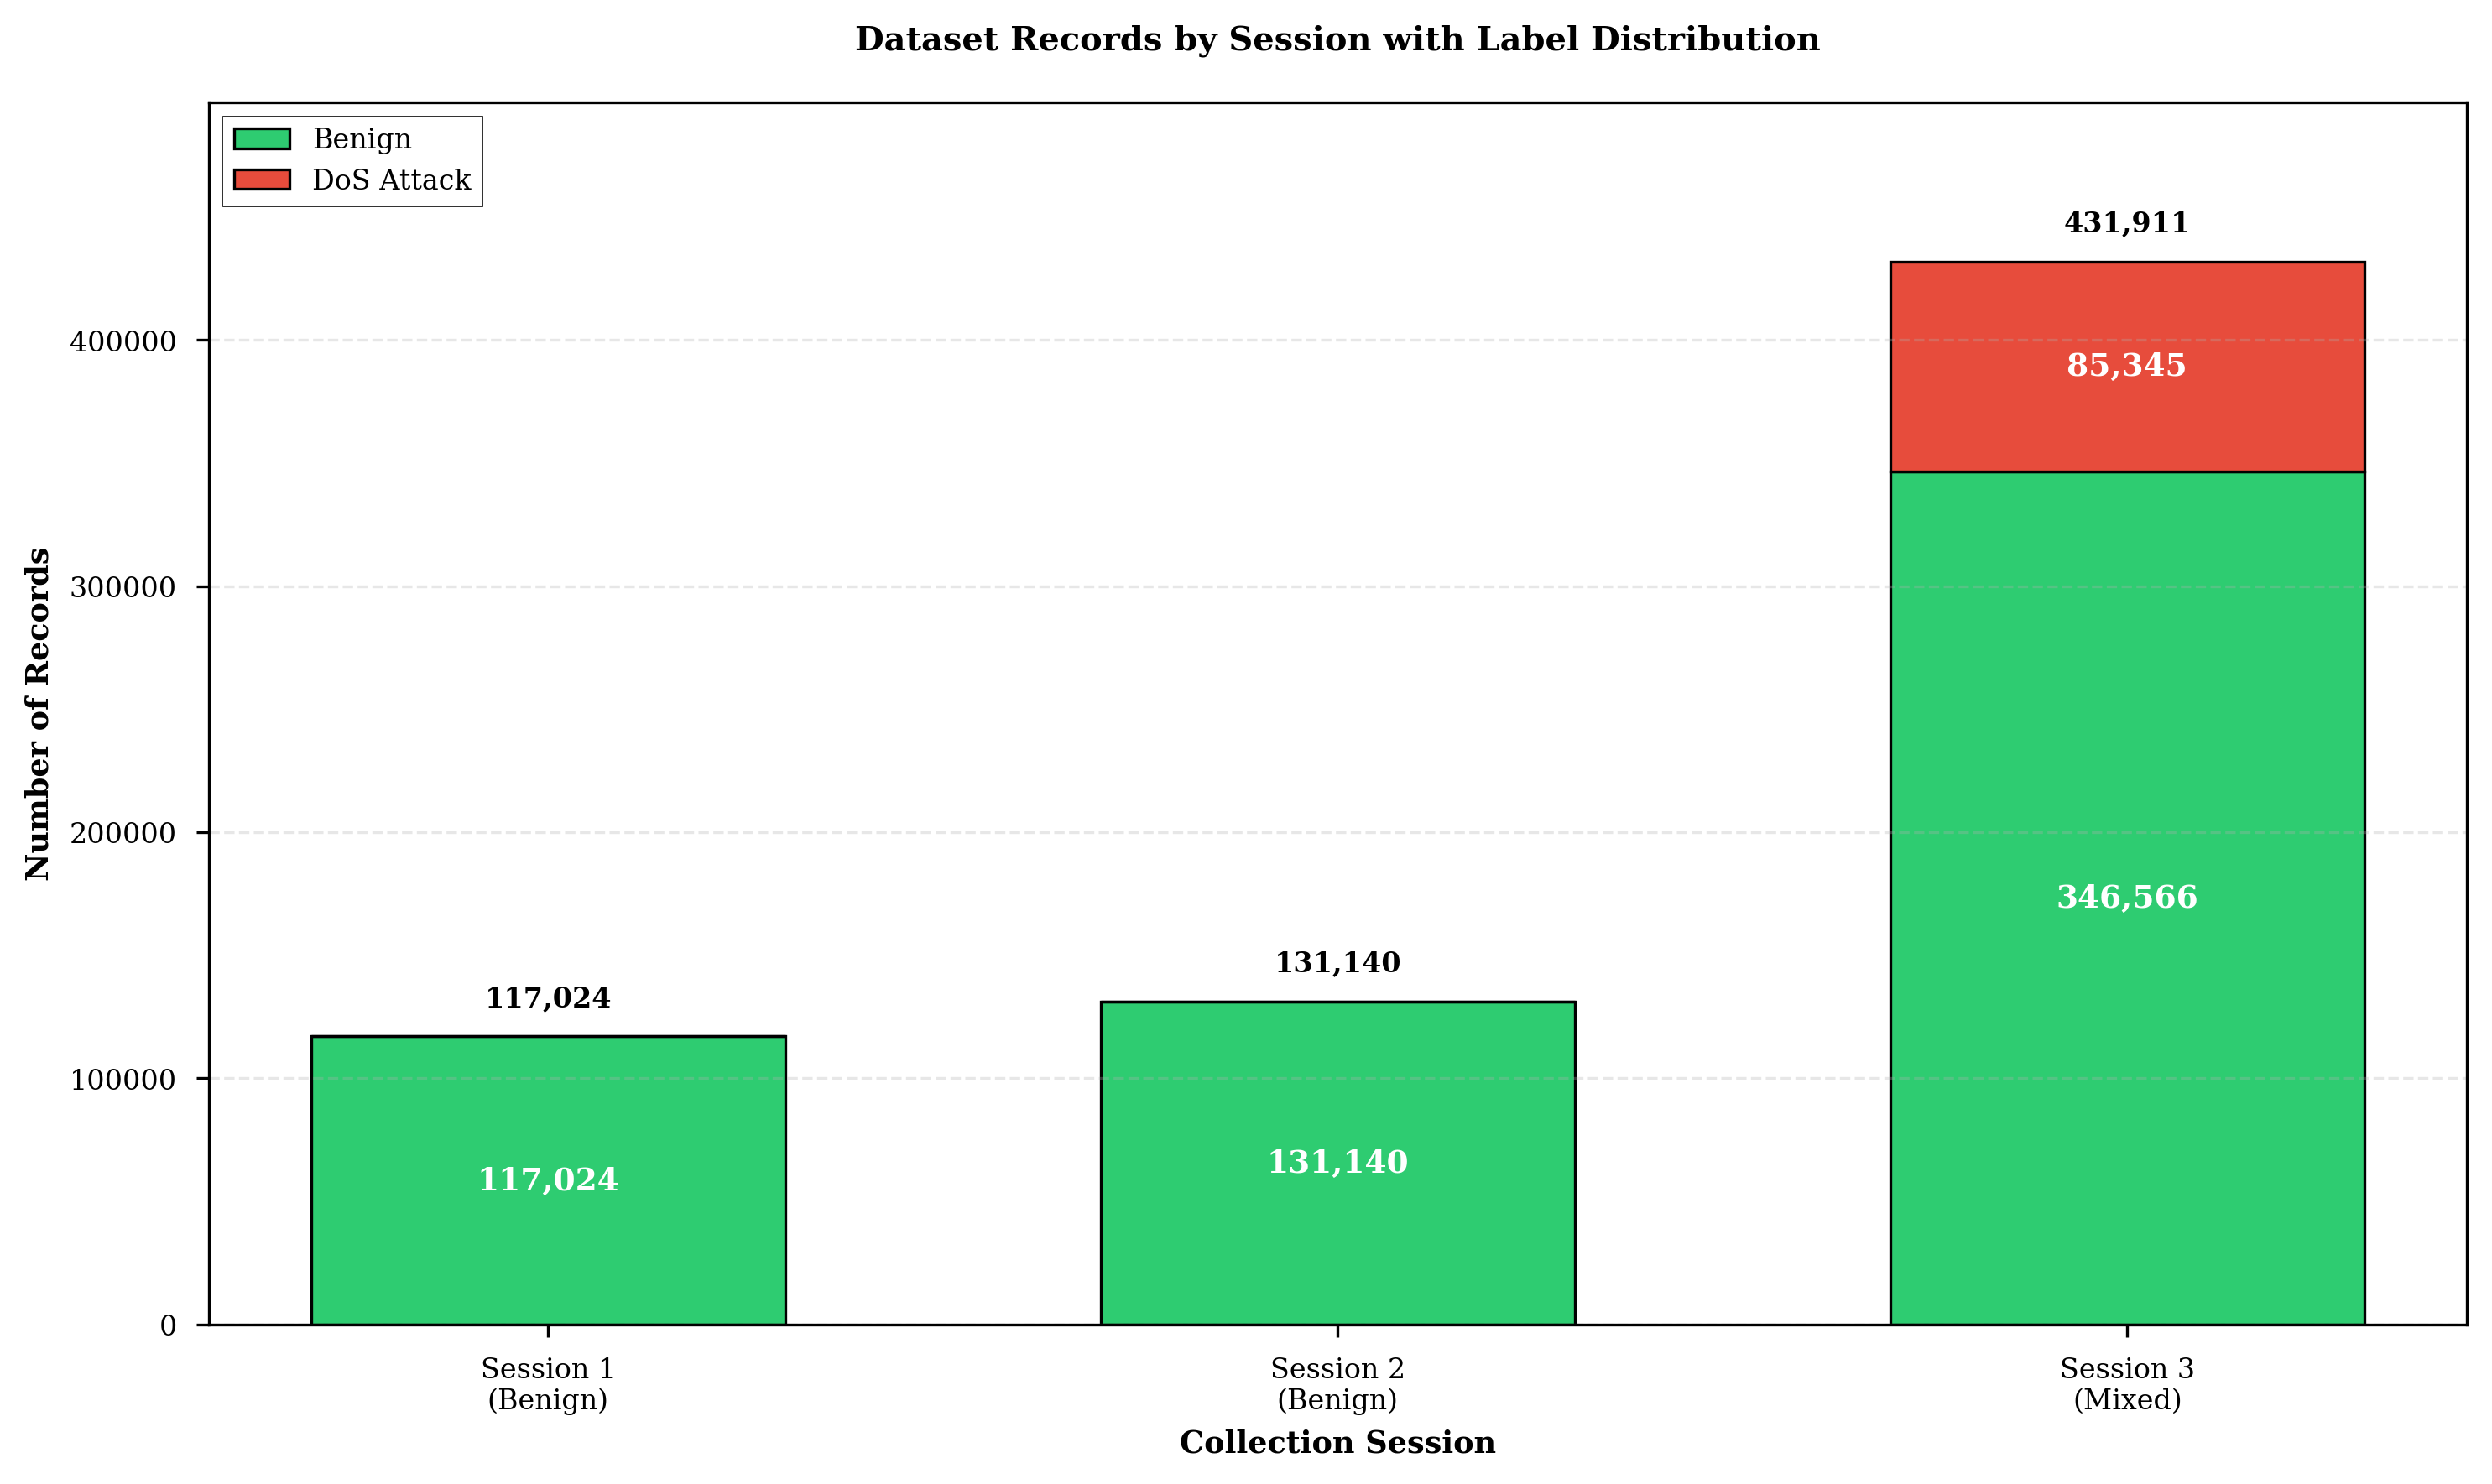

✅ All visualizations generated successfully!

Generated files:
  1. dataset_sessions_stacked.png - Records per session by protocol layer
  2. dataset_distribution_pies.png - Label and layer distribution pie charts
  3. dataset_mac_rlc_grouped.png - MAC vs RLC grouped comparison
  4. dataset_sessions_labels.png - Session records with benign/DoS breakdown

All figures saved at 300 DPI for publication quality.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'serif'


sessions = ['Session 1\n(Benign)', 'Session 2\n(Benign)', 'Session 3\n(Mixed)']
mac_records = [64128, 71632, 221043]
rlc_records = [52896, 59508, 210868]
total_records = [117024, 131140, 431911]

fig1, ax1 = plt.subplots(figsize=(8, 5))

x = np.arange(len(sessions))
width = 0.5

p1 = ax1.bar(x, mac_records, width, label='MAC Layer', color='#3498db', edgecolor='black', linewidth=0.5)
p2 = ax1.bar(x, rlc_records, width, bottom=mac_records, label='RLC Layer', color='#e74c3c', edgecolor='black', linewidth=0.5)

for i, (mac, rlc, total) in enumerate(zip(mac_records, rlc_records, total_records)):
    ax1.text(i, mac/2, f'{mac:,}', ha='center', va='center', fontweight='bold', color='white', fontsize=9)
    ax1.text(i, mac + rlc/2, f'{rlc:,}', ha='center', va='center', fontweight='bold', color='white', fontsize=9)
    ax1.text(i, total + 10000, f'Total: {total:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax1.set_ylabel('Number of Records', fontweight='bold')
ax1.set_xlabel('Collection Session', fontweight='bold')
ax1.set_title('Dataset Records Distribution by Session and Protocol Layer', fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(sessions)
ax1.legend(loc='upper left', frameon=True, fancybox=False, edgecolor='black')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, max(total_records) * 1.15)

plt.tight_layout()
plt.savefig('dataset_sessions_stacked.png', dpi=300, bbox_inches='tight')
plt.show()


fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 5))


labels_data = [594730, 85345]
labels_names = ['Benign\n(87.45%)', 'Malicious (DoS)\n(12.55%)']
colors1 = ['#2ecc71', '#e74c3c']
explode1 = (0.05, 0.05)

wedges1, texts1, autotexts1 = ax2.pie(labels_data, labels=labels_names, autopct='%1.1f%%',
                                        colors=colors1, explode=explode1, startangle=90,
                                        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
                                        textprops={'fontweight': 'bold'})
for autotext in autotexts1:
    autotext.set_color('white')
    autotext.set_fontsize(11)
ax2.set_title('Label Distribution\n(Total: 680,075 records)', fontweight='bold', pad=15)


layer_data = [356803, 323272]
layer_names = ['MAC Layer\n(52.45%)', 'RLC Layer\n(47.55%)']
colors2 = ['#3498db', '#9b59b6']
explode2 = (0.05, 0.05)

wedges2, texts2, autotexts2 = ax3.pie(layer_data, labels=layer_names, autopct='%1.1f%%',
                                        colors=colors2, explode=explode2, startangle=90,
                                        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
                                        textprops={'fontweight': 'bold'})
for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_fontsize(11)
ax3.set_title('Protocol Layer Distribution\n(Total: 680,075 records)', fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('dataset_distribution_pies.png', dpi=300, bbox_inches='tight')
plt.show()


fig3, ax4 = plt.subplots(figsize=(9, 5))

x = np.arange(len(sessions))
width = 0.35

bars1 = ax4.bar(x - width/2, mac_records, width, label='MAC Layer',
                color='#3498db', edgecolor='black', linewidth=0.8)
bars2 = ax4.bar(x + width/2, rlc_records, width, label='RLC Layer',
                color='#e74c3c', edgecolor='black', linewidth=0.8)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

ax4.set_ylabel('Number of Records', fontweight='bold')
ax4.set_xlabel('Collection Session', fontweight='bold')
ax4.set_title('MAC vs RLC Layer Records by Session', fontweight='bold', pad=15)
ax4.set_xticks(x)
ax4.set_xticklabels(sessions)
ax4.legend(loc='upper left', frameon=True, fancybox=False, edgecolor='black')
ax4.grid(axis='y', alpha=0.3, linestyle='--')
ax4.set_ylim(0, max(mac_records) * 1.2)

plt.tight_layout()
plt.savefig('dataset_mac_rlc_grouped.png', dpi=300, bbox_inches='tight')
plt.show()


fig4, ax5 = plt.subplots(figsize=(10, 6))


sessions_full = ['Session 1\n(Benign)', 'Session 2\n(Benign)', 'Session 3\n(Mixed)']
benign_records = [117024, 131140, 346566]
dos_records = [0, 0, 85345]
x = np.arange(len(sessions_full))
width = 0.6

p1 = ax5.bar(x, benign_records, width, label='Benign', color='#2ecc71', edgecolor='black', linewidth=0.8)
p2 = ax5.bar(x, dos_records, width, bottom=benign_records, label='DoS Attack', color='#e74c3c', edgecolor='black', linewidth=0.8)


for i, (benign, dos) in enumerate(zip(benign_records, dos_records)):
    total = benign + dos
    if benign > 0:
        ax5.text(i, benign/2, f'{benign:,}', ha='center', va='center', fontweight='bold', color='white', fontsize=9)
    if dos > 0:
        ax5.text(i, benign + dos/2, f'{dos:,}', ha='center', va='center', fontweight='bold', color='white', fontsize=9)
    ax5.text(i, total + 10000, f'{total:,}', ha='center', va='bottom', fontweight='bold', fontsize=8)

ax5.set_ylabel('Number of Records', fontweight='bold')
ax5.set_xlabel('Collection Session', fontweight='bold')
ax5.set_title('Dataset Records by Session with Label Distribution', fontweight='bold', pad=15)
ax5.set_xticks(x)
ax5.set_xticklabels(sessions_full)
ax5.legend(loc='upper left', frameon=True, fancybox=False, edgecolor='black')
ax5.grid(axis='y', alpha=0.3, linestyle='--')
ax5.set_ylim(0, max([b+d for b, d in zip(benign_records, dos_records)]) * 1.15)

plt.tight_layout()
plt.savefig('dataset_sessions_labels.png', dpi=300, bbox_inches='tight')
plt.show()
